In [2]:
import pandas as pd, numpy as np
from fidap import fidap_client
import config

In [3]:
fidap = fidap_client(api_key=config.FIDAP_API_KEY)

Let's first explore the data and find some basic numbers here.

In [4]:
df2 = fidap.sql("""
    select insider_trades.ticker, insider_trades.filingdate, insider_trades.transactionshares,
    insider_trades.transactionvalue, daily.close, daily.fc_1m, daily.marketcap
    from insider_trades, tickers, daily
    where 
    insider_trades.ticker = tickers.ticker and 
    insider_trades.ticker = daily.ticker and
    insider_trades.filingdate = daily.date and
    insider_trades.transactionvalue > 100000 and 
    insider_trades.securitytitle = 'Common Stock'
""")

In [5]:
df2.head()

,ticker,filingdate,transactionshares,transactionvalue,close,fc_1m,marketcap
0,CMO,2016-02-03,13937,129893,9.47,0.033791,907500000.0
1,CMO,2016-02-03,24881,231891,9.47,0.033791,907500000.0
2,CMO,2016-02-03,17414,162298,9.47,0.033791,907500000.0
3,CMO,2016-02-03,11105,103499,9.47,0.033791,907500000.0
4,CMO,2018-01-04,43604,374994,8.66,-0.005774,832300000.0


In [6]:
len(df2)

276005

In [7]:
df2['mc_pct'] = df2['transactionvalue'] / (df2['marketcap']*1e6)

In [8]:
df2['sale'] = np.where(df2['transactionshares'] > 0, False, True)

In [9]:
df2

,ticker,filingdate,transactionshares,transactionvalue,close,fc_1m,marketcap,mc_pct,sale
0,CMO,2016-02-03,13937,129893,9.47,0.033791,9.075000e+08,1.431328e-10,False
1,CMO,2016-02-03,24881,231891,9.47,0.033791,9.075000e+08,2.555273e-10,False
2,CMO,2016-02-03,17414,162298,9.47,0.033791,9.075000e+08,1.788408e-10,False
3,CMO,2016-02-03,11105,103499,9.47,0.033791,9.075000e+08,1.140485e-10,False
4,CMO,2018-01-04,43604,374994,8.66,-0.005774,8.323000e+08,4.505515e-10,False
...,...,...,...,...,...,...,...,...,...
276000,WPC,2016-11-17,4000,230920,57.07,0.060803,6.065400e+09,3.807169e-11,False
276001,WPC,2019-02-21,-17648,1326953,74.40,0.047446,1.198310e+10,1.107354e-10,True
276002,WPC,2019-02-21,-19180,1442144,74.40,0.047446,1.198310e+10,1.203482e-10,True
276003,WPC,2019-02-21,-2085,156771,74.40,0.047446,1.198310e+10,1.308267e-11,True


In [10]:
df2 = df2.dropna()

In [11]:
features = ['close', 'marketcap', 'mc_pct', 'sale']
label = 'fc_1m'

In [13]:
!pip install xgboost

     |████████████████████████████████| 157.5 MB 50 kB/s s eta 0:00:01


In [14]:
import xgboost as xgb

In [15]:
model = xgb.XGBRegressor()

In [16]:
model.fit(df2[features],df2[label])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
preds = model.predict(df2[features])

In [21]:
df2['predict'] = preds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
df2

,ticker,filingdate,transactionshares,transactionvalue,close,fc_1m,marketcap,mc_pct,sale,predict
0,CMO,2016-02-03,13937,129893,9.47,0.033791,9.075000e+08,1.431328e-10,False,0.050187
1,CMO,2016-02-03,24881,231891,9.47,0.033791,9.075000e+08,2.555273e-10,False,0.046775
2,CMO,2016-02-03,17414,162298,9.47,0.033791,9.075000e+08,1.788408e-10,False,0.050187
3,CMO,2016-02-03,11105,103499,9.47,0.033791,9.075000e+08,1.140485e-10,False,0.011469
4,CMO,2018-01-04,43604,374994,8.66,-0.005774,8.323000e+08,4.505515e-10,False,0.014673
...,...,...,...,...,...,...,...,...,...,...
276000,WPC,2016-11-17,4000,230920,57.07,0.060803,6.065400e+09,3.807169e-11,False,0.010236
276001,WPC,2019-02-21,-17648,1326953,74.40,0.047446,1.198310e+10,1.107354e-10,True,0.015925
276002,WPC,2019-02-21,-19180,1442144,74.40,0.047446,1.198310e+10,1.203482e-10,True,0.015925
276003,WPC,2019-02-21,-2085,156771,74.40,0.047446,1.198310e+10,1.308267e-11,True,0.015043


In [23]:
df2[df2['predict'] > 0]['fc_1m'].mean()

0.026718258681903955

In [24]:
df2[df2['predict'] < 0]['fc_1m'].mean()

-0.050443428344466294

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

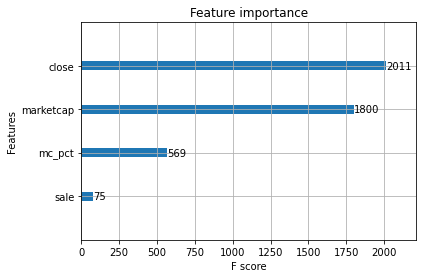

In [25]:
xgb.plot_importance(model)
